In [12]:
!pip install pymatgen
!pip install factor_analyzer
!pip install openpyxl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.6/55.6 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 55.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.9/119.9 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 809.1/809.1 kB 46.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 788.2/788.2 kB 45.6 MB/s eta 0:00:00
  Created wheel for bibtexparser: filename=bibtexparser-1.4.3-py3-none-any.whl size=43549 sha256=74e5870e2f6cc293d19720fc51f19f178e682303849ca0ac84ec488a07c84aab
  Stored in directory: /root/.cache/pip/wheels/1f/7d/e9/1ff2509f13767a55df1279744adfb757f4ab94b2cbe761f56a
Successfully built bibtexparser
     ━━━━━━━━━━━━━━━━━

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle

from pymatgen.core.composition import Composition
from scipy import stats
from scipy.stats import norm, shapiro, normaltest, anderson, gaussian_kde, linregress

from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo

# Warning configuration to clean output
warnings.filterwarnings("ignore")

In [18]:
class VectorizeFormula:
    def __init__(self):
        with open(r"elem_dict.pkl", "rb") as f:
            elem_dict  = pickle.load(f)
        self.element_df = pd.DataFrame(elem_dict)
        self.column_names = []
        for string in ['avg','sum','var','range']:
            for column_name in self.element_df.columns.values:
                self.column_names.append(string+'_'+column_name)

    def _assign_features(self, formula):
        '''
        Parameters
        ----------
        formula: string
           put a valid chemical fomula as a sting. Example( 'NaCl')

        Return
        ----------
        features: np.array()
            This is an 1xN length array containing feature values for use in the
            machine learning model.
        '''
        try:
            fractional_composition = Composition(formula).fractional_composition.as_dict()
            element_composition = Composition(formula).element_composition.as_dict()
            avg_feature = np.zeros(len(self.element_df.iloc[0]))
            sum_feature = np.zeros(len(self.element_df.iloc[0]))
            for key in fractional_composition:
                try:
                    avg_feature += self.element_df.loc[key].values * fractional_composition[key]
                    sum_feature += self.element_df.loc[key].values * element_composition[key]
                except:
                    print('The element:', key, 'from formula', formula,'is not currently supported in our database')
                    return np.array([np.nan]*len(self.element_df.iloc[0])*4)
            var_feature = self.element_df.loc[list(fractional_composition.keys())].var()
            range_feature = self.element_df.loc[list(fractional_composition.keys())].max()-self.element_df.loc[list(fractional_composition.keys())].min()

            features = pd.DataFrame(np.concatenate([avg_feature, sum_feature, np.array(var_feature), np.array(range_feature)]))
            features = np.concatenate([avg_feature, sum_feature, np.array(var_feature), np.array(range_feature)])
            return features.transpose()
        except:
            print('There was and error with the Formula: '+ formula + ', this is a general exception with an unkown error')
            return [np.nan]*len(self.element_df.iloc[0])*4
    def generate_features(self, df, reset_index=False):
        '''
        Parameters
        ----------
        df: Pandas.DataFrame()
            Two column dataframe of form:
                df.columns.values = array(['formula', 'target'], dtype=object)

        Return
        ----------
        x_fill_fill_fill: pd.DataFrame()
            Feature Matrix with NaN values filled using the median feature value for dataset
        y: pd.Series()
            Target values
        '''

        # make empty list where we will store the feature vectors
        features = []
        # make empty list where we will store the property value
        targets = []
        # add the values to the list using a for loop
        for formula, target in zip(df['formula'], df['target']):
            features.append(self._assign_features(formula))
            targets.append(target)
        # split feature vectors and targets as X and y
        X = pd.DataFrame(features, columns=self.column_names, index=df.index.values)
        y = pd.Series(targets, index=df.index.values)
        # drop elements that aren't included in the elmenetal properties list.
        # These will be returned as feature rows completely full of Nan values.
        X.dropna(inplace=True, how='all')
        y = y.loc[X.index]
        y.name = 'target'
        formula = df['formula'].loc[X.index]
        if reset_index is True:
            # reset dataframe indices to simplify code later.
            X.reset_index(drop=True, inplace=True)
            y.reset_index(drop=True, inplace=True)
        # get the column names
        cols = X.columns.values
        # find the mean value of each column
        median_values = X[cols].median()
        # fill the missing values in each column with the columns mean value
        X[cols] = X[cols].fillna(median_values.iloc[0])
        return X, y, formula

In [21]:
vf = VectorizeFormula()
# Load data
df = pd.read_csv(r"band_gap_download.csv")
# Average duplicates
df = df.groupby('composition').mean().reset_index()
# Rename columns
df.columns = ['formula', 'target']
# --- FILTER FIRST: Only rows with target > 0 ---
df = df[df['target'] > 0].reset_index(drop=True)
# --- APPLY 99th PERCENTILE ---
p99 = df['target'].quantile(0.99)
df = df[df['target'] <= p99].reset_index(drop=True)
print(f"Data before features:")
print(f"  Rows with target > 0: {len(df)}")
print(f"  99th Percentile: {p99:.4f}")
print(f"  Target range: [{df['target'].min():.4f}, {df['target'].max():.4f}]")
X, y, formulas = vf.generate_features(df)
y = y.values.astype(float)
print(f"\nData after features:")
print(f"  Samples: {len(y)}")
print(f"  Shape X: {X.shape}")
cov_matrix = X.cov()

Data before features:
  Rows with target > 0: 2459
  99th Percentile: 7.3000
  Target range: [0.0200, 7.3000]

Data after features:
  Samples: 2459
  Shape X: (2459, 228)


In [22]:
X.to_csv(r"X_features.csv", index=False)

In [23]:
print(vf.element_df.columns)
print(len(vf.element_df.columns))

Index(['Atomic_Number', 'Atomic_Weight', 'Period', 'group', 'families',
       'Mendele_Number', 'l_quantum_number', 'Atomic_Radus',
       'Miracle_Radius_[pm]', 'Covalent_Radius', 'Zunger_radii_sum',
       'ionic_radius', 'Orbital_Radius(pm)', 'crystal_radius',
       'Pauling_Electronegativity', 'MB_electonegativity',
       'Nagle_electonegativity', 'Pearson_abs_electonegativity',
       'Gordy_electonegativity', 'Mulliken_EN',
       'Allred-Rockow_electronegativity', 'metallic_valence',
       'number_of_valence_electrons', 'gilmor_number_of_valence_electron',
       'valence_s', 'valence_p', 'valence_d', 'valence_f',
       'Number_of_unfilled_s_valence_electrons',
       'Number_of_unfilled_p_valence_electrons',
       'Number_of_unfilled_d_valence_electrons',
       'Number_of_unfilled_f_valence_electrons', 'outer_shell_electrons',
       '1st_ionization_potential_(kJ/mol)', 'polarizability(A^3)',
       'Melting_point_(K)', 'Boiling_Point_(K)', 'Molar_Denstiy_(mol/ml)',
    

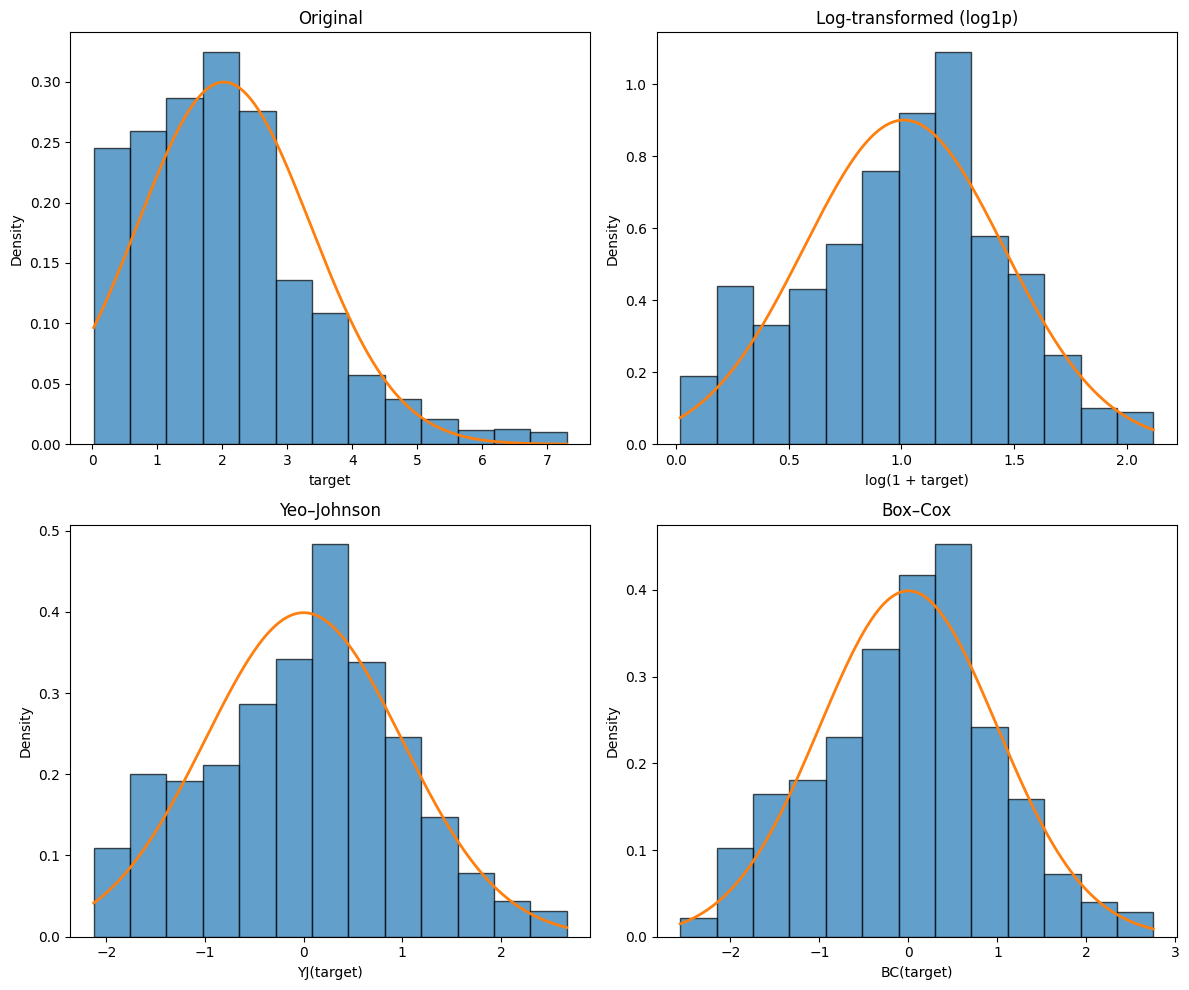

In [24]:
y_fill = y.copy()
# -----------------------------
# Transformations
# -----------------------------
# Log(1+y)
y_log = np.log1p(y_fill)

# Yeo–Johnson
pt_yj = PowerTransformer(method='yeo-johnson')
y_yj = pt_yj.fit_transform(y_fill.reshape(-1, 1)).ravel()

# Box–Cox (only if all > 0)
can_boxcox = np.all(y_fill > 0)
if can_boxcox:
    pt_bc = PowerTransformer(method='box-cox')
    y_bc = pt_bc.fit_transform(y_fill.reshape(-1, 1)).ravel()
else:
    y_bc = None

# -----------------------------
# Function to plot with superimposed normal PDF
# -----------------------------
def plot_with_normal(ax, data, title, xlabel):
    ax.hist(data, bins="sturges", alpha=0.7, density=True, edgecolor='black')

    mu, sigma = np.mean(data), np.std(data)
    x = np.linspace(data.min(), data.max(), 400)
    pdf = norm.pdf(x, mu, sigma)

    ax.plot(x, pdf, lw=2)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Density")

fig, ax = plt.subplots(2, 2, figsize=(12, 10))
plot_with_normal(ax[0, 0], y_fill, "Original", "target")
plot_with_normal(ax[0, 1], y_log, "Log-transformed (log1p)", "log(1 + target)")
plot_with_normal(ax[1, 0], y_yj, "Yeo–Johnson", "YJ(target)")
if y_bc is not None:
    plot_with_normal(ax[1, 1], y_bc, "Box–Cox", "BC(target)")
else:
    ax[1, 1].text(0.5, 0.5, "Box–Cox not applicable\n(values ≤ 0)",
                 ha='center', va='center', fontsize=12)
    ax[1, 1].set_xticks([])
    ax[1, 1].set_yticks([])
    ax[1, 1].set_title("Box–Cox")

plt.tight_layout()
plt.show()

In [25]:
# ====================================================================
# NORMALITY TESTS
# ====================================================================

# Function to test normality
def pruebas_normalidad(x, nombre):
    print(f"\n===== {nombre} =====")

    # Shapiro–Wilk
    stat_sh, p_sh = shapiro(x)
    print(f"Shapiro-Wilk:      stat={stat_sh:.4f}, p={p_sh:.4e}")

    # D'Agostino K² (normaltest)
    stat_k2, p_k2 = normaltest(x)
    print(f"D’Agostino K²:     stat={stat_k2:.4f}, p={p_k2:.4e}")

    # Anderson–Darling
    ad = anderson(x)
    print(f"Anderson-Darling:  stat={ad.statistic:.4f}")
    print("  Critical values:", ad.critical_values)
    print("  Significances:  ", ad.significance_level)

    # Quick conclusion
    if p_sh > 0.05 and p_k2 > 0.05:
        print("→ ACCEPTS normality (p > 0.05 in both).")
    else:
        print("→ REJECTS normality (p ≤ 0.05 in either).")


# -----------------------------
# Run tests for each
# -----------------------------
pruebas_normalidad(y_fill, "Original")
pruebas_normalidad(y_log, "Log(1+y)")
pruebas_normalidad(y_yj, "Yeo–Johnson")
pruebas_normalidad(y_bc, "Box–Cox")


===== Original =====
Shapiro-Wilk:      stat=0.9405, p=2.3160e-30
D’Agostino K²:     stat=346.7182, p=5.1417e-76
Anderson-Darling:  stat=26.5772
  Critical values: [0.575 0.655 0.786 0.917 1.09 ]
  Significances:   [15.  10.   5.   2.5  1. ]
→ REJECTS normality (p ≤ 0.05 in either).

===== Log(1+y) =====
Shapiro-Wilk:      stat=0.9855, p=3.8123e-15
D’Agostino K²:     stat=53.2327, p=2.7585e-12
Anderson-Darling:  stat=10.2523
  Critical values: [0.575 0.655 0.786 0.917 1.09 ]
  Significances:   [15.  10.   5.   2.5  1. ]
→ REJECTS normality (p ≤ 0.05 in either).

===== Yeo–Johnson =====
Shapiro-Wilk:      stat=0.9878, p=1.1655e-13
D’Agostino K²:     stat=33.6470, p=4.9392e-08
Anderson-Darling:  stat=7.0037
  Critical values: [0.575 0.655 0.786 0.917 1.09 ]
  Significances:   [15.  10.   5.   2.5  1. ]
→ REJECTS normality (p ≤ 0.05 in either).

===== Box–Cox =====
Shapiro-Wilk:      stat=0.9917, p=1.1169e-10
D’Agostino K²:     stat=8.9295, p=1.1508e-02
Anderson-Darling:  stat=6.4866
  C

START: EXPLORATORY FACTOR ANALYSIS
Original dimensions: (2459, 228)
After removing constant variables: (2459, 228)
Standardized data: Mean = 0, Std. Dev. = 1

Step 2: Remove extreme multicollinearity (correlation > 0.95)
Removed (redundant) variables: 66
Final dimensions for analysis: (2459, 162)

Step 3: Factor Analysis Adequacy Tests
------------------------------------------------------------
Bartlett test p-value: 0.0000e+00
  Interpretation: P = 0.0 indicates that variables are correlated
KMO Index (Kaiser-Meyer-Olkin): 0.874
  Interpretation: Values > 0.6 indicate adequacy for FA

Step 4: Determination of optimal number of factors
------------------------------------------------------------


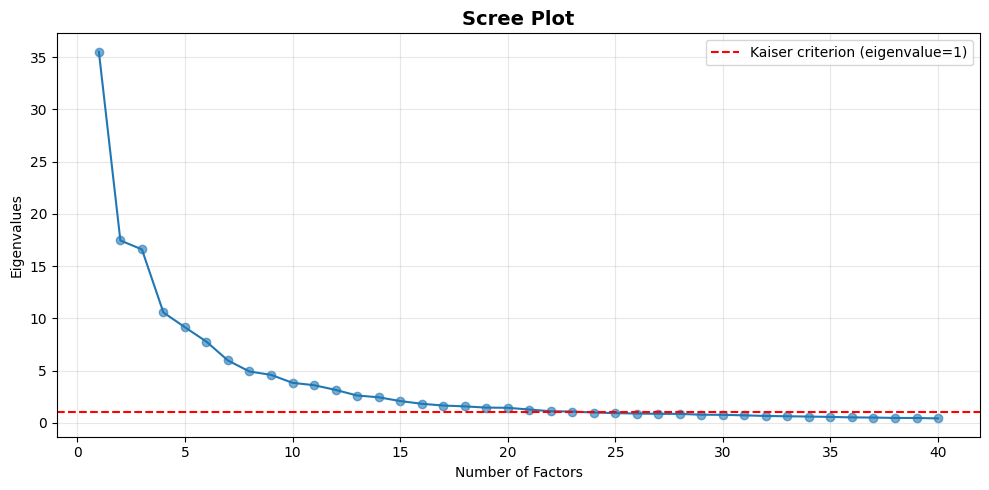


Step 5: Final factor model fitting
------------------------------------------------------------
Number of factors selected: 20
Model fitted with Varimax rotation

Step 6: Extraction of factor interpretation
------------------------------------------------------------

Variance Explained by Factor:
                        Factor 1   Factor 2   Factor 3   Factor 4   Factor 5  \
Variance SS            18.833385  17.013887  11.593864  10.329024  10.135821   
Proportional Variance   0.116255   0.105024   0.071567   0.063759   0.062567   
Cumulative Variance     0.116255   0.221279   0.292847   0.356606   0.419173   

                       Factor 6  Factor 7  Factor 8  Factor 9  Factor 10  \
Variance SS            8.166159  7.218778  6.378288  6.331888   5.921828   
Proportional Variance  0.050408  0.044560  0.039372  0.039086   0.036554   
Cumulative Variance    0.469581  0.514141  0.553514  0.592599   0.629154   

                       Factor 11  Factor 12  Factor 13  Factor 14  Factor 

In [26]:
# ====================================================================
# EXPLORATORY FACTOR ANALYSIS (EFA)
# ====================================================================

# Step 1: Data Preparation
# Cleaning of variables with no variance (constants) and standardization is performed.
# This is critical to avoid numerical errors in singular matrices.

X_clean = X.copy()

print("="*60)
print("START: EXPLORATORY FACTOR ANALYSIS")
print("="*60)
print(f"Original dimensions: {X_clean.shape}")

# 1A. Remove zero-variance columns (constants)
X_clean = X_clean.loc[:, X_clean.std() > 0]
print(f"After removing constant variables: {X_clean.shape}")

# 1B. Data Standardization
# Transforms variables to have mean 0 and std. dev. 1
scaler = StandardScaler()
X_scaled_array = scaler.fit_transform(X_clean)
X_clean = pd.DataFrame(X_scaled_array, columns=X_clean.columns)
print("Standardized data: Mean = 0, Std. Dev. = 1")

# Step 2: Remove extreme multicollinearity
# Variables with correlation > 0.95 are redundant and can cause singular matrices
print("\nStep 2: Remove extreme multicollinearity (correlation > 0.95)")

corr_matrix = X_clean.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] >= 0.95)]

if to_drop:
    print(f"Removed (redundant) variables: {len(to_drop)}")
    X_clean = X_clean.drop(columns=to_drop)
else:
    print("No redundant variables found (correlation < 0.95)")

print(f"Final dimensions for analysis: {X_clean.shape}")

# Step 3: Factor Analysis Adequacy Tests
# Verify if the data is suitable for factorization

print("\nStep 3: Factor Analysis Adequacy Tests")
print("-" * 60)

try:
    chi_square_value, p_value = calculate_bartlett_sphericity(X_clean)
    print(f"Bartlett test p-value: {p_value:.4e}")
    print(f"  Interpretation: P = 0.0 indicates that variables are correlated")
except Exception as e:
    print(f"Bartlett error: {e}")

kmo_all, kmo_model = calculate_kmo(X_clean)
print(f"KMO Index (Kaiser-Meyer-Olkin): {kmo_model:.3f}")
print(f"  Interpretation: Values > 0.6 indicate adequacy for FA")

# Step 4: Determine optimal number of factors
# Eigenvalue analysis is used

print("\nStep 4: Determination of optimal number of factors")
print("-" * 60)

fa = FactorAnalyzer(rotation=None)
fa.fit(X_clean)
ev, v = fa.get_eigenvalues()
num = 40

# Scree Plot
# Shows the variance explained by each factor
plt.figure(figsize=(10, 5))
plt.scatter(range(1, num+1), ev[0:num], alpha=0.6)
plt.plot(range(1, num+1), ev[0:num], linewidth=1.5)
plt.title('Scree Plot', fontsize=14, fontweight='bold')
plt.xlabel('Number of Factors')
plt.ylabel('Eigenvalues')
plt.axhline(y=1, color='r', linestyle='--', label='Kaiser criterion (eigenvalue=1)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Step 5: Final factor model fitting
# 20 factors are selected with Varimax rotation for interpretability
print("\nStep 5: Final factor model fitting")
print("-" * 60)
n_factores_elegidos = 20
print(f"Number of factors selected: {n_factores_elegidos}")

fa_final = FactorAnalyzer(n_factors=n_factores_elegidos, rotation='varimax')
fa_final.fit(X_clean)
print("Model fitted with Varimax rotation")
# Step 6: Extraction of loadings and explained variance
# Loadings indicate which variables compose each factor
print("\nStep 6: Extraction of factor interpretation")
print("-" * 60)

cargas = pd.DataFrame(fa_final.loadings_,
                      index=X_clean.columns,
                      columns=[f'Factor {i+1}' for i in range(n_factores_elegidos)])

varianza = pd.DataFrame(fa_final.get_factor_variance(),
                        index=['Variance SS', 'Proportional Variance', 'Cumulative Variance'],
                        columns=[f'Factor {i+1}' for i in range(n_factores_elegidos)])

print("\nVariance Explained by Factor:")
print(varianza)
# Step 7: Obtaining factor scores (latent variables)
# These new variables will be used in subsequent modeling
print("\nStep 7: Generation of factor scores")
print("-" * 60)
X_factores = fa_final.transform(X_clean)
print(f"Factor matrix shape: {X_factores.shape}")
print("Latent variables successfully generated")

SUMMARY: PRINCIPAL VARIABLES BY FACTOR (Loading > 0.5)

Factor 1 - Dominant variables:
var_Nagle_electonegativity                 0.895316
var_Pauling_Electronegativity              0.865415
var_1st_ionization_potential_(kJ/mol)      0.841187
var_Gordy_electonegativity                 0.818923
var_Mulliken_EN                            0.811146
range_Nagle_electonegativity               0.798067
var_MB_electonegativity                    0.791583
range_1st_ionization_potential_(kJ/mol)    0.749022
range_Gordy_electonegativity               0.741564
range_Pauling_Electronegativity            0.725117
range_Mulliken_EN                          0.709304
range_MB_electonegativity                  0.661198
range_Molar_Heat_Capacity(J/mol_K)         0.638922
avg_Gordy_electonegativity                 0.607072
range_Pearson_abs_electonegativity         0.570920
avg_Pauling_Electronegativity              0.546921
var_Molar_Heat_Capacity(J/mol_K)           0.538531
var_Orbital_Radius(pm)       

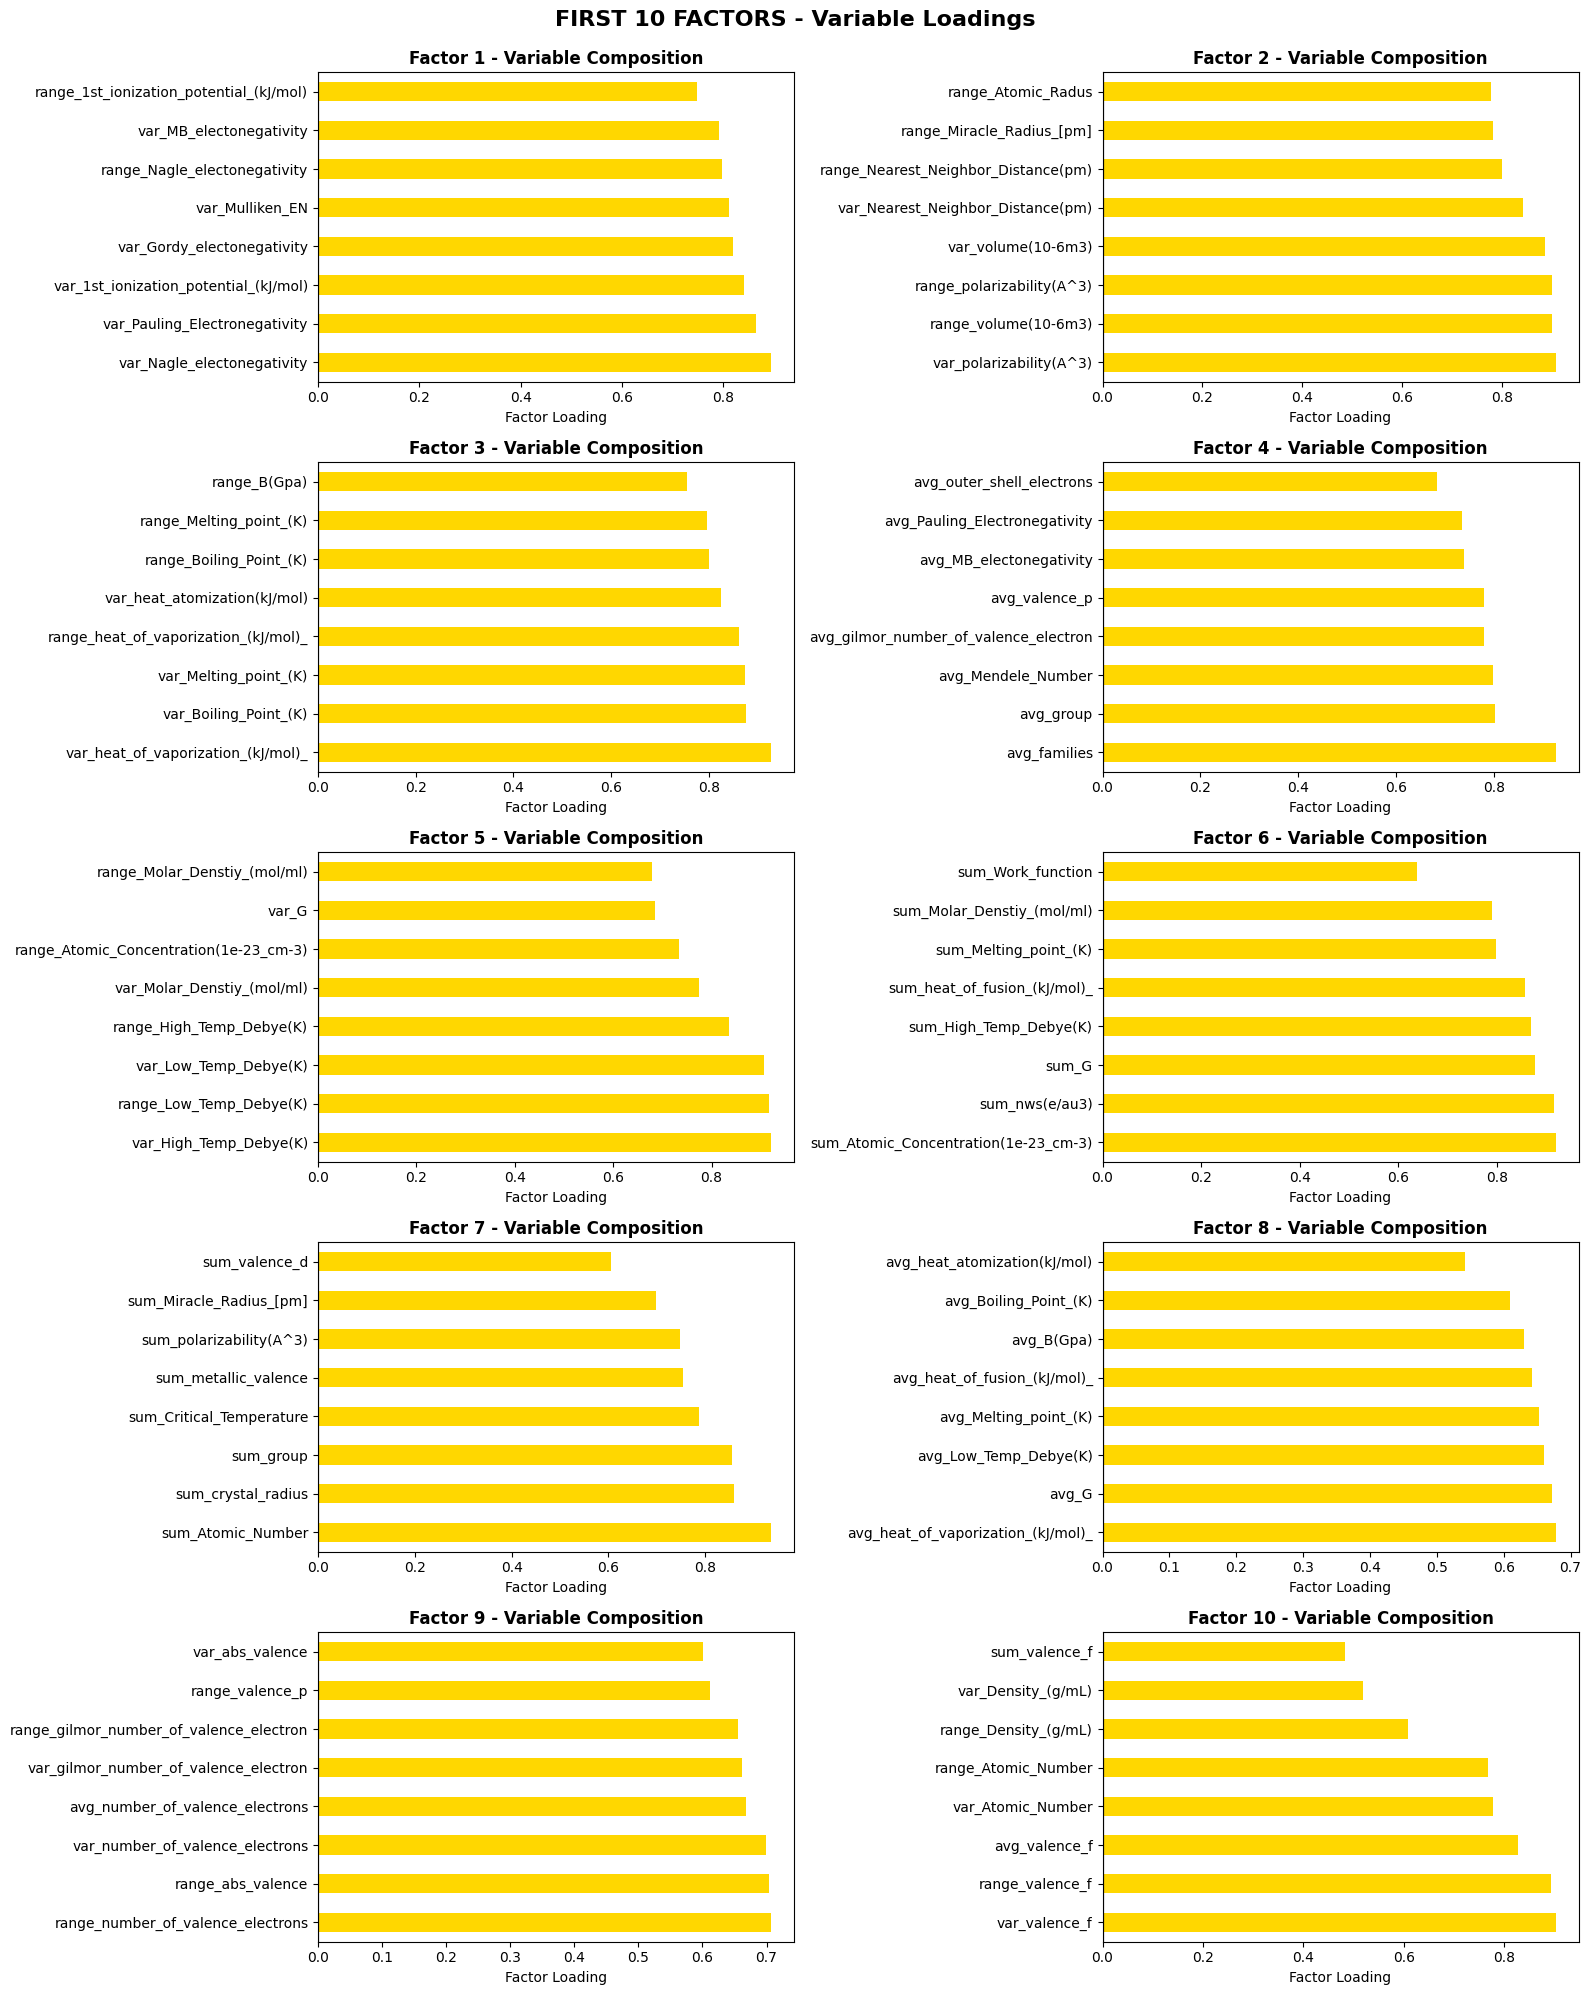


VISUALIZATION: LAST 10 FACTORS


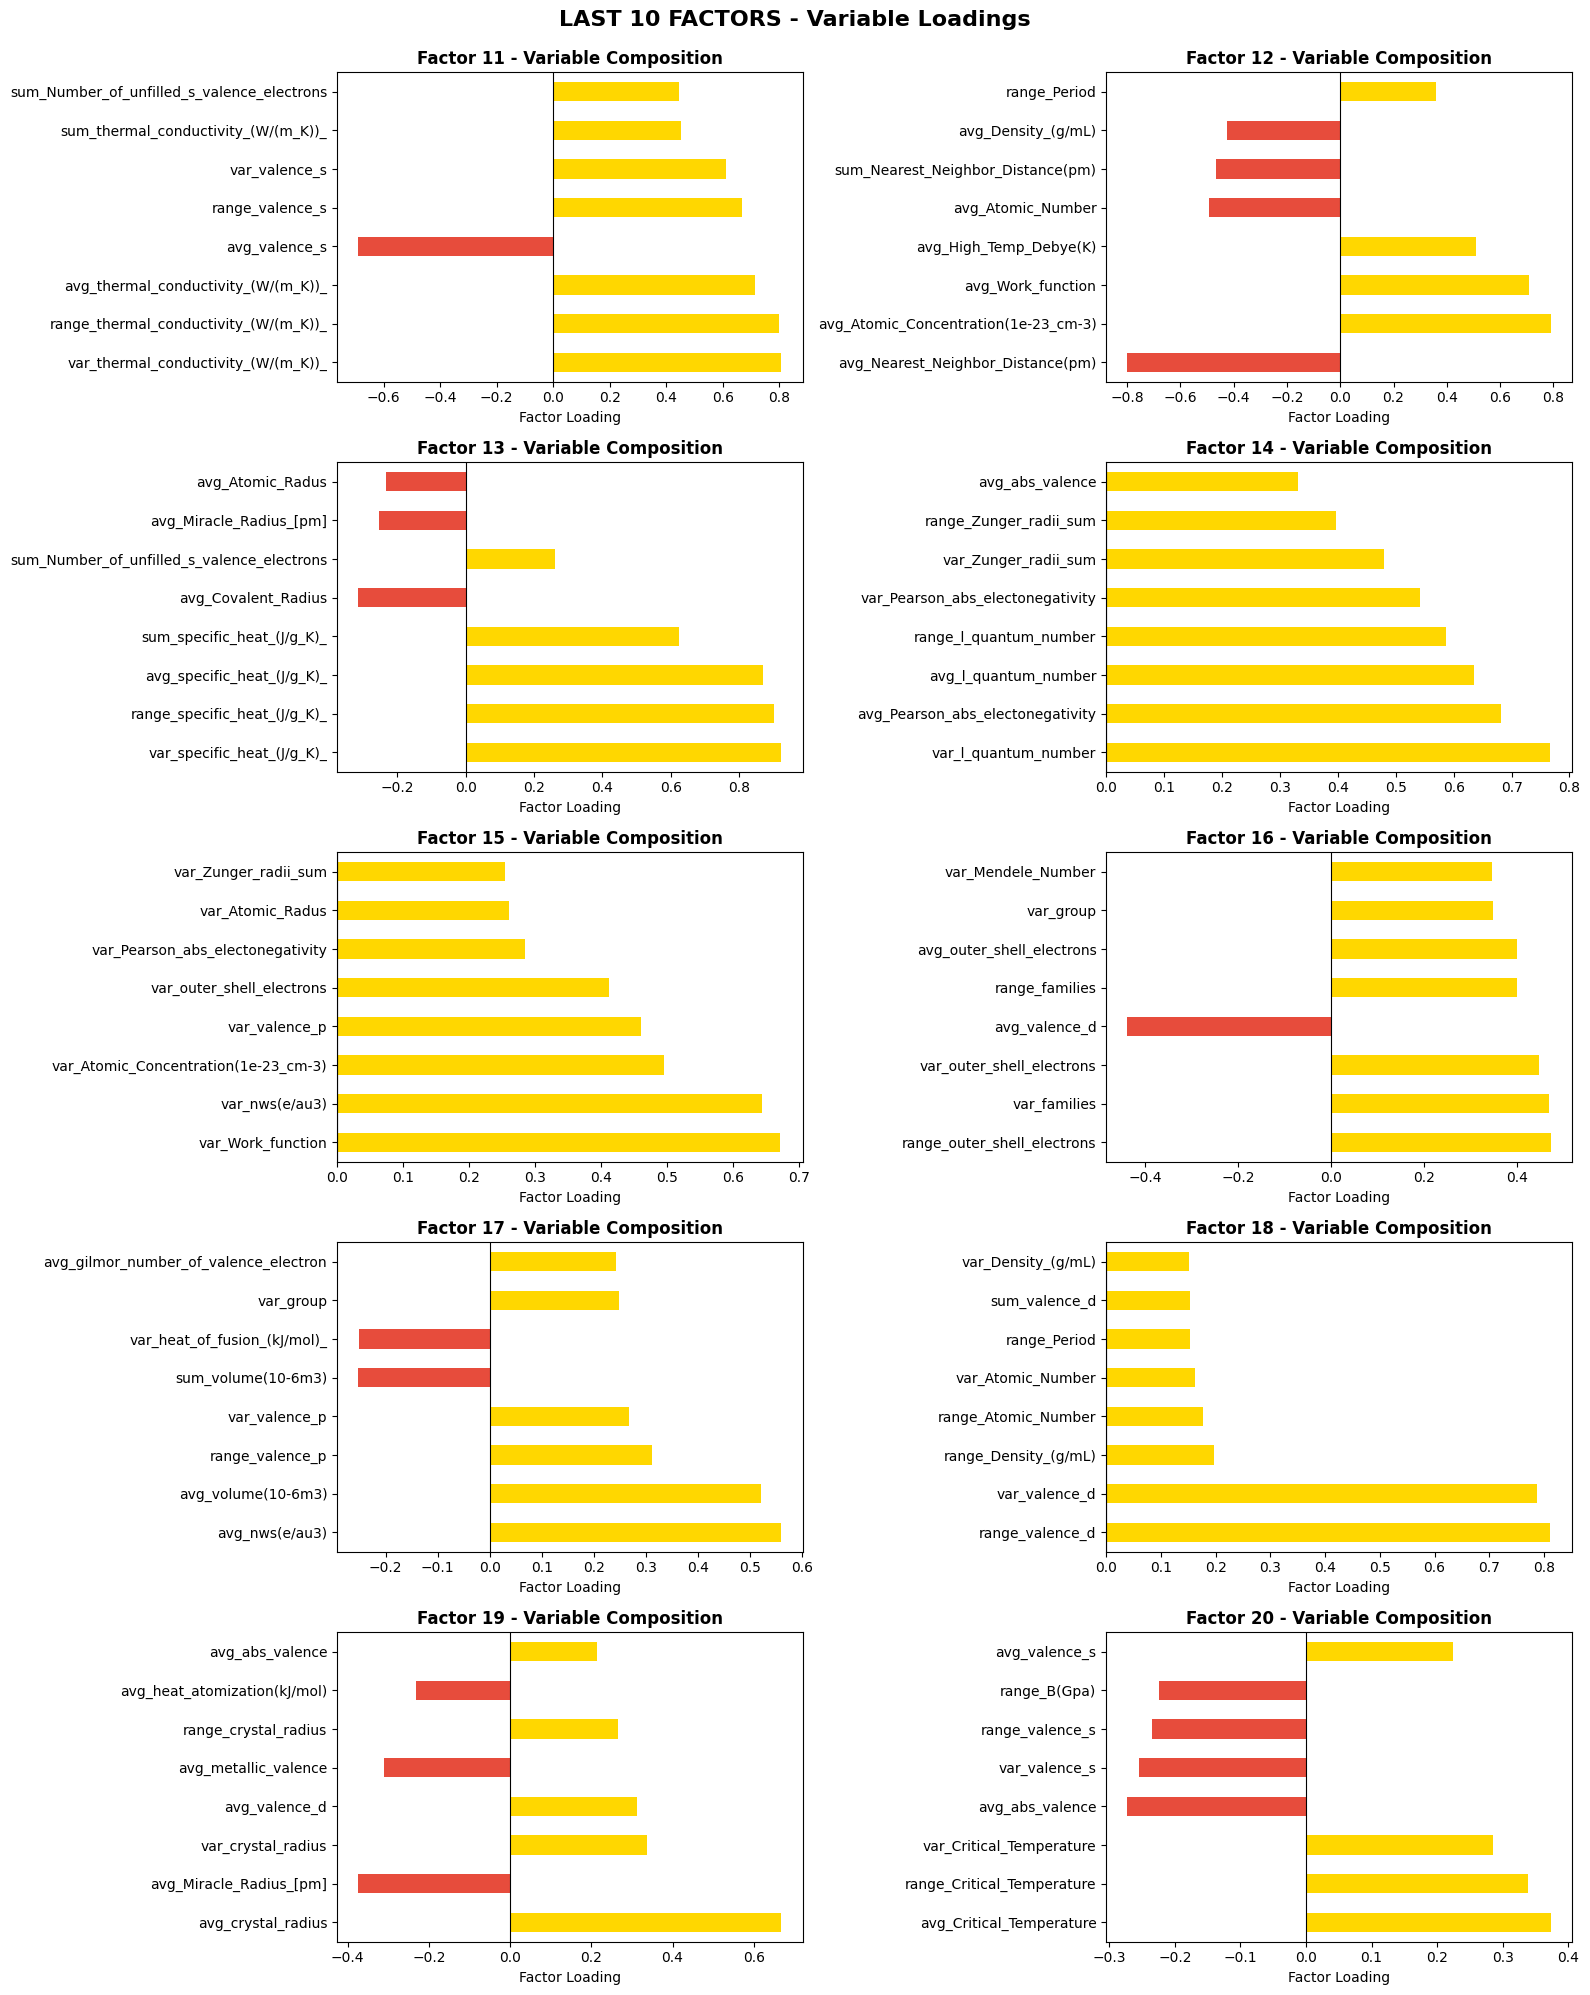


Visualizations completed: 20 factors represented in two plots


In [27]:

# ====================================================================
# FACTOR INTERPRETATION AND VISUALIZATION
# ====================================================================

# Step 1: Create Factor Loadings DataFrame
# Loadings show the correlation between original variables and factors

cargas = pd.DataFrame(fa_final.loadings_,
                      index=X_clean.columns,
                      columns=[f'Factor {i+1}' for i in range(n_factores_elegidos)])

# Step 2: Summary of principal variables per factor
# Loadings greater than 0.5 are filtered to identify the most important ones

print("="*60)
print("SUMMARY: PRINCIPAL VARIABLES BY FACTOR (Loading > 0.5)")
print("="*60)

redundancia_tracker = {}

for factor in cargas.columns:
    vars_importantes = cargas[factor][cargas[factor].abs() > 0.5].sort_values(ascending=False)

    if not vars_importantes.empty:
        print(f"\n{factor} - Dominant variables:")
        print(vars_importantes.to_string())

        if len(vars_importantes) > 1:
            redundancia_tracker[factor] = list(vars_importantes.index)
    else:
        print(f"\n{factor} - No clear dominant variables")

# Step 3: Visualization - First 10 factors
# Horizontal bar charts showing the 8 variables with the highest loading

print("\n" + "="*60)
print("VISUALIZATION: FIRST 10 FACTORS")
print("="*60)

fig1, axes1 = plt.subplots(5, 2, figsize=(16, 20))
axes1 = axes1.flatten()

for i in range(10):
    factor_name = f'Factor {i+1}'
    ax = axes1[i]

    # Select 8 variables with highest absolute loading
    top_cargas = cargas[factor_name].abs().sort_values(ascending=False).head(8).index
    subset = cargas.loc[top_cargas, factor_name]

    # Assign colors: Yellow for positive, Red for negative
    colors = ["#FFD700" if x > 0 else '#e74c3c' for x in subset.values]

    subset.plot(kind='barh', ax=ax, color=colors)
    ax.set_title(f'{factor_name} - Variable Composition', fontsize=12, fontweight='bold')
    ax.axvline(0, color='black', linewidth=0.8)
    ax.set_xlabel("Factor Loading")

plt.suptitle("FIRST 10 FACTORS - Variable Loadings", fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# Step 4: Visualization - Last 10 factors

print("\n" + "="*60)
print("VISUALIZATION: LAST 10 FACTORS")
print("="*60)

fig2, axes2 = plt.subplots(5, 2, figsize=(16, 20))
axes2 = axes2.flatten()

for i in range(10, 20):
    factor_name = f'Factor {i+1}'
    ax = axes2[i-10]

    # Select 8 variables with highest absolute loading
    top_cargas = cargas[factor_name].abs().sort_values(ascending=False).head(8).index
    subset = cargas.loc[top_cargas, factor_name]

    # Assign colors: Yellow for positive, Red for negative
    colors = ["#FFD700" if x > 0 else '#e74c3c' for x in subset.values]

    subset.plot(kind='barh', ax=ax, color=colors)
    ax.set_title(f'{factor_name} - Variable Composition', fontsize=12, fontweight='bold')
    ax.axvline(0, color='black', linewidth=0.8)
    ax.set_xlabel("Factor Loading")

plt.suptitle("LAST 10 FACTORS - Variable Loadings", fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("\nVisualizations completed: 20 factors represented in two plots")

ANALYSIS: Distributions of the 20 Latent Factors
Shape of X_factores: (2459, 20)
Histograms with superimposed KDE are visualized for each factor


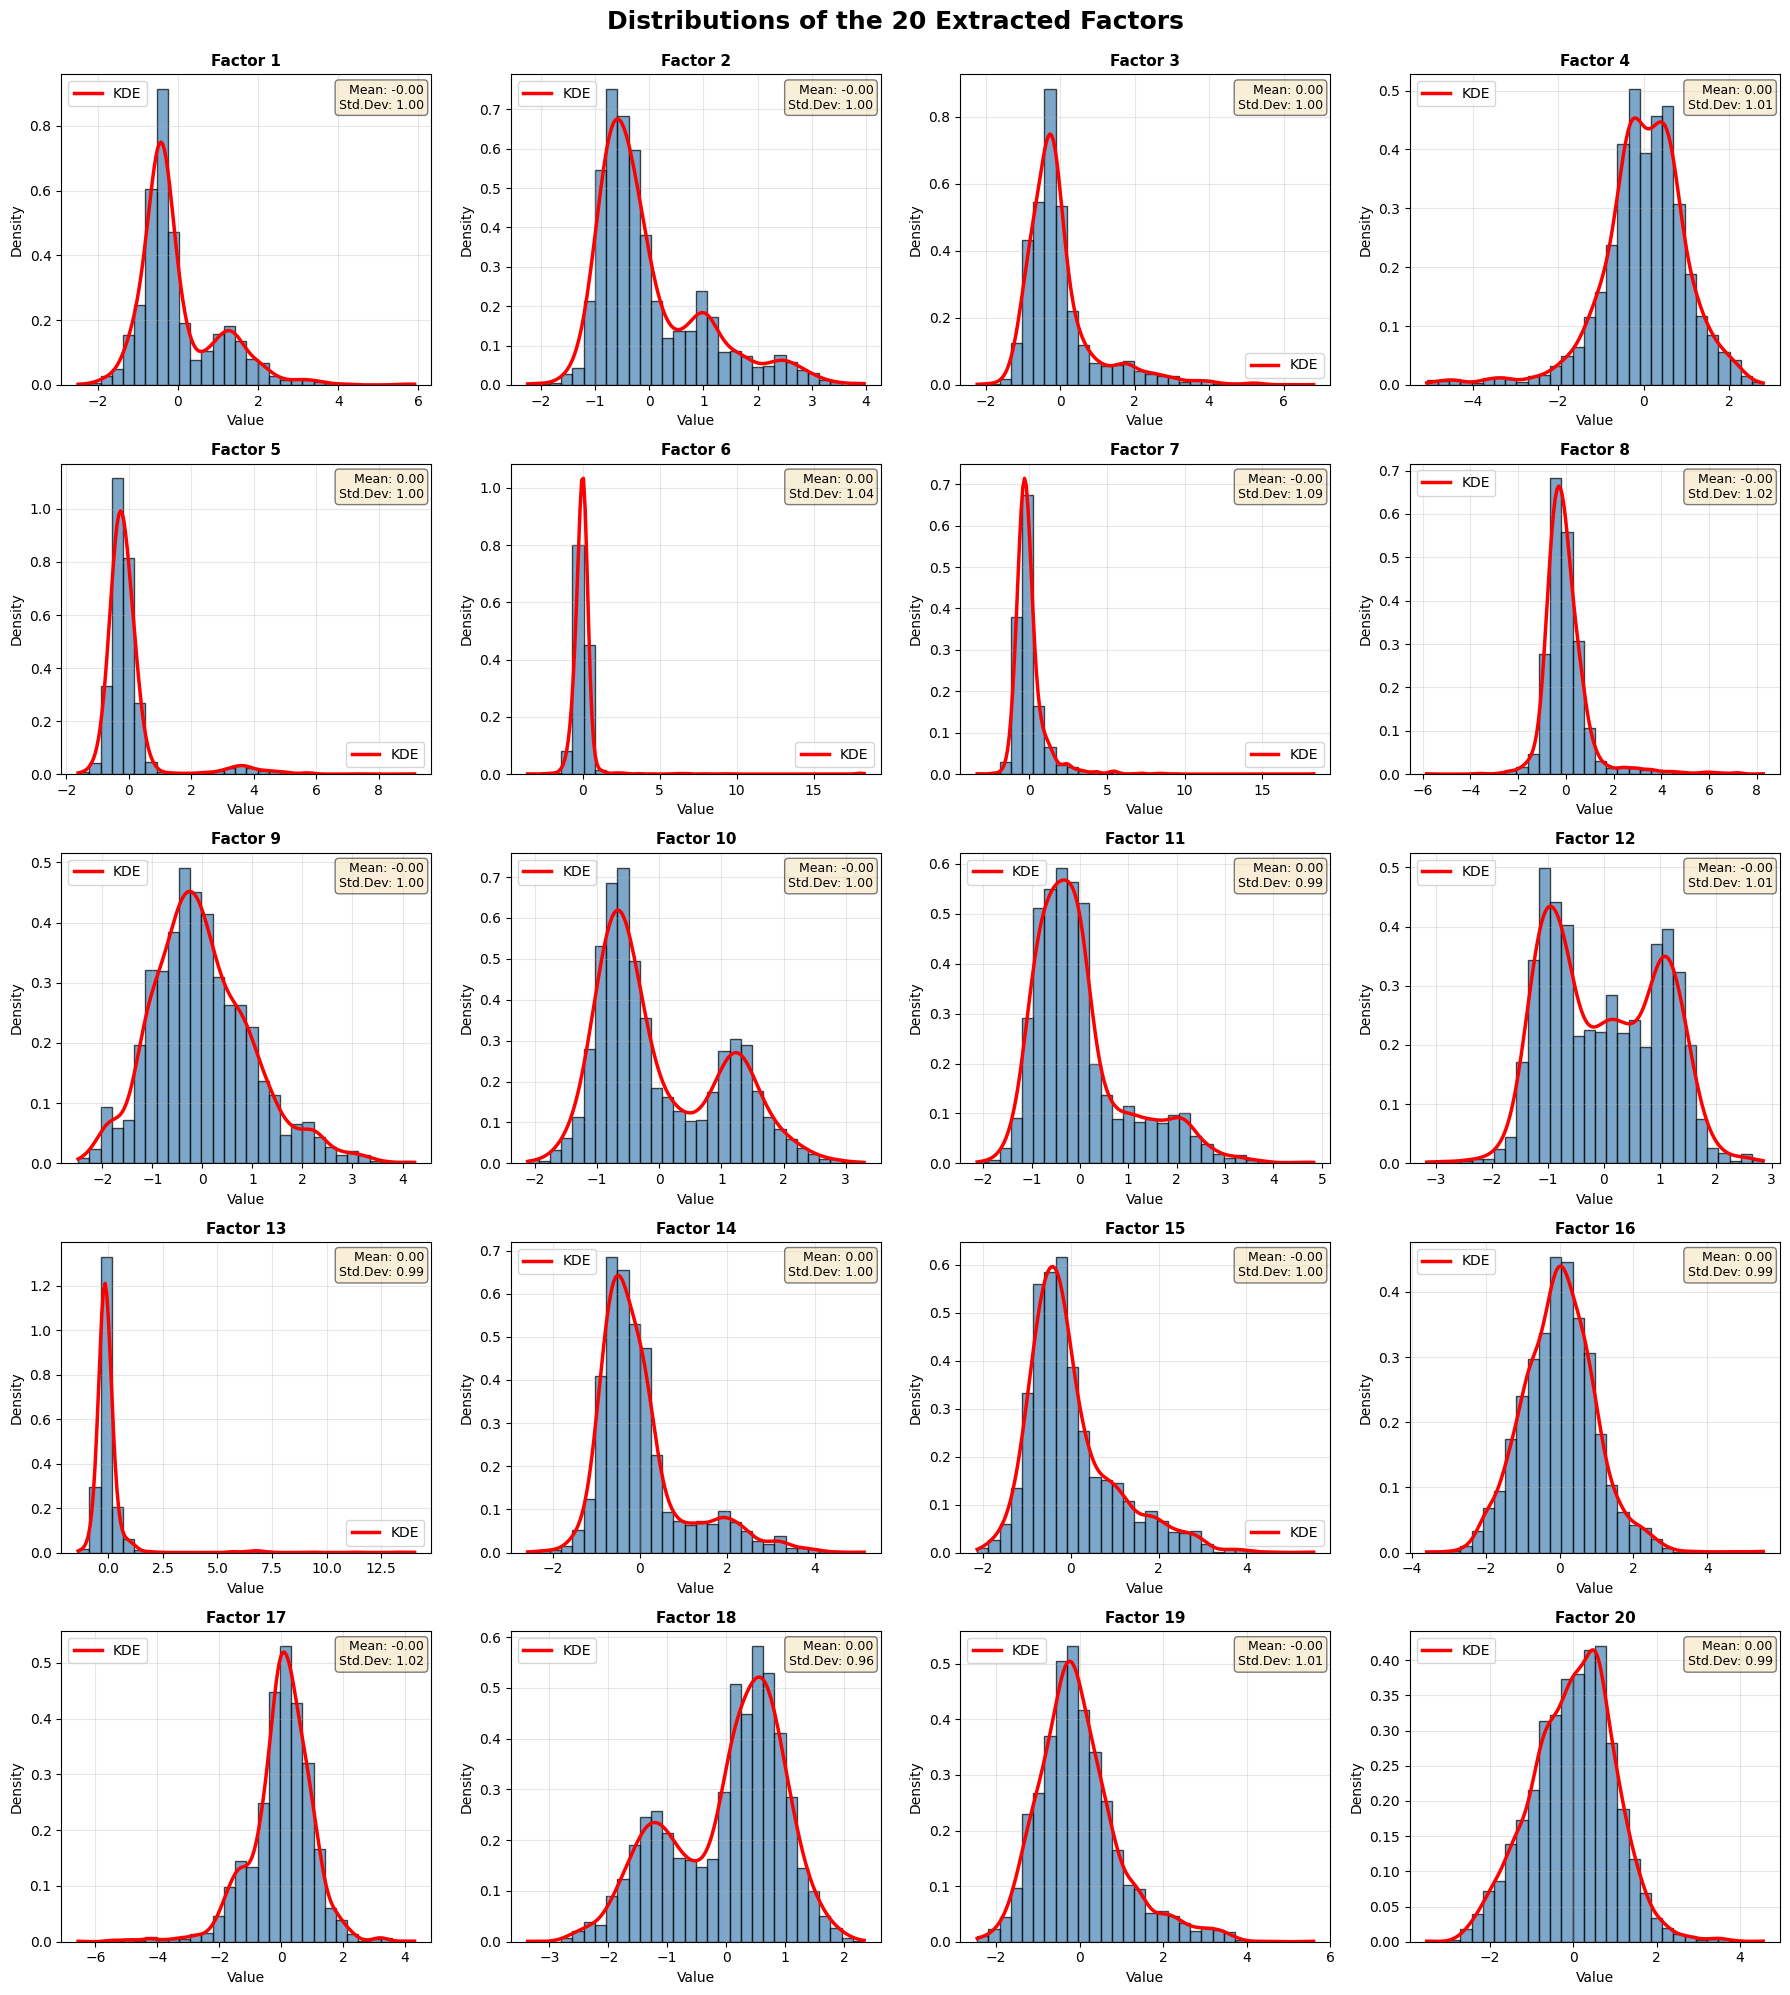


Plot completed: 5 rows x 4 columns = 20 factors
Each panel shows histogram, KDE, mean, and standard deviation


In [28]:

# ====================================================================
# ANALYSIS OF THE 20 FACTOR DISTRIBUTIONS
# ====================================================================

print("="*60)
print("ANALYSIS: Distributions of the 20 Latent Factors")
print("="*60)
print(f"Shape of X_factores: {X_factores.shape}")
print(f"Histograms with superimposed KDE are visualized for each factor")

# Create grid of 5 rows x 4 columns (20 plots)
fig, axes = plt.subplots(5, 4, figsize=(18, 20))
axes = axes.flatten()

for i in range(20):
    factor_data = X_factores[:, i]
    ax = axes[i]

    # Histogram with normalized density
    ax.hist(factor_data, bins=30, alpha=0.7, color='steelblue', edgecolor='black', density=True)

    # Superimpose KDE (Kernel Density Estimation) to visualize smooth distribution
    kde = gaussian_kde(factor_data)
    x_range = np.linspace(factor_data.min(), factor_data.max(), 200)
    ax.plot(x_range, kde(x_range), 'r-', lw=2.5, label='KDE')

    # Configure labels and titles
    ax.set_title(f'Factor {i+1}', fontsize=11, fontweight='bold')
    ax.set_xlabel('Value')
    ax.set_ylabel('Density')
    ax.grid(True, alpha=0.3)
    ax.legend()

    # Display mean and standard deviation
    media = np.mean(factor_data)
    std = np.std(factor_data)
    ax.text(0.98, 0.97, f'Mean: {media:.2f}\nStd.Dev: {std:.2f}',
            transform=ax.transAxes, fontsize=9,
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle('Distributions of the 20 Extracted Factors', fontsize=18, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("\nPlot completed: 5 rows x 4 columns = 20 factors")
print("Each panel shows histogram, KDE, mean, and standard deviation")

ANALYSIS: Relationship between Factors and Response Variable


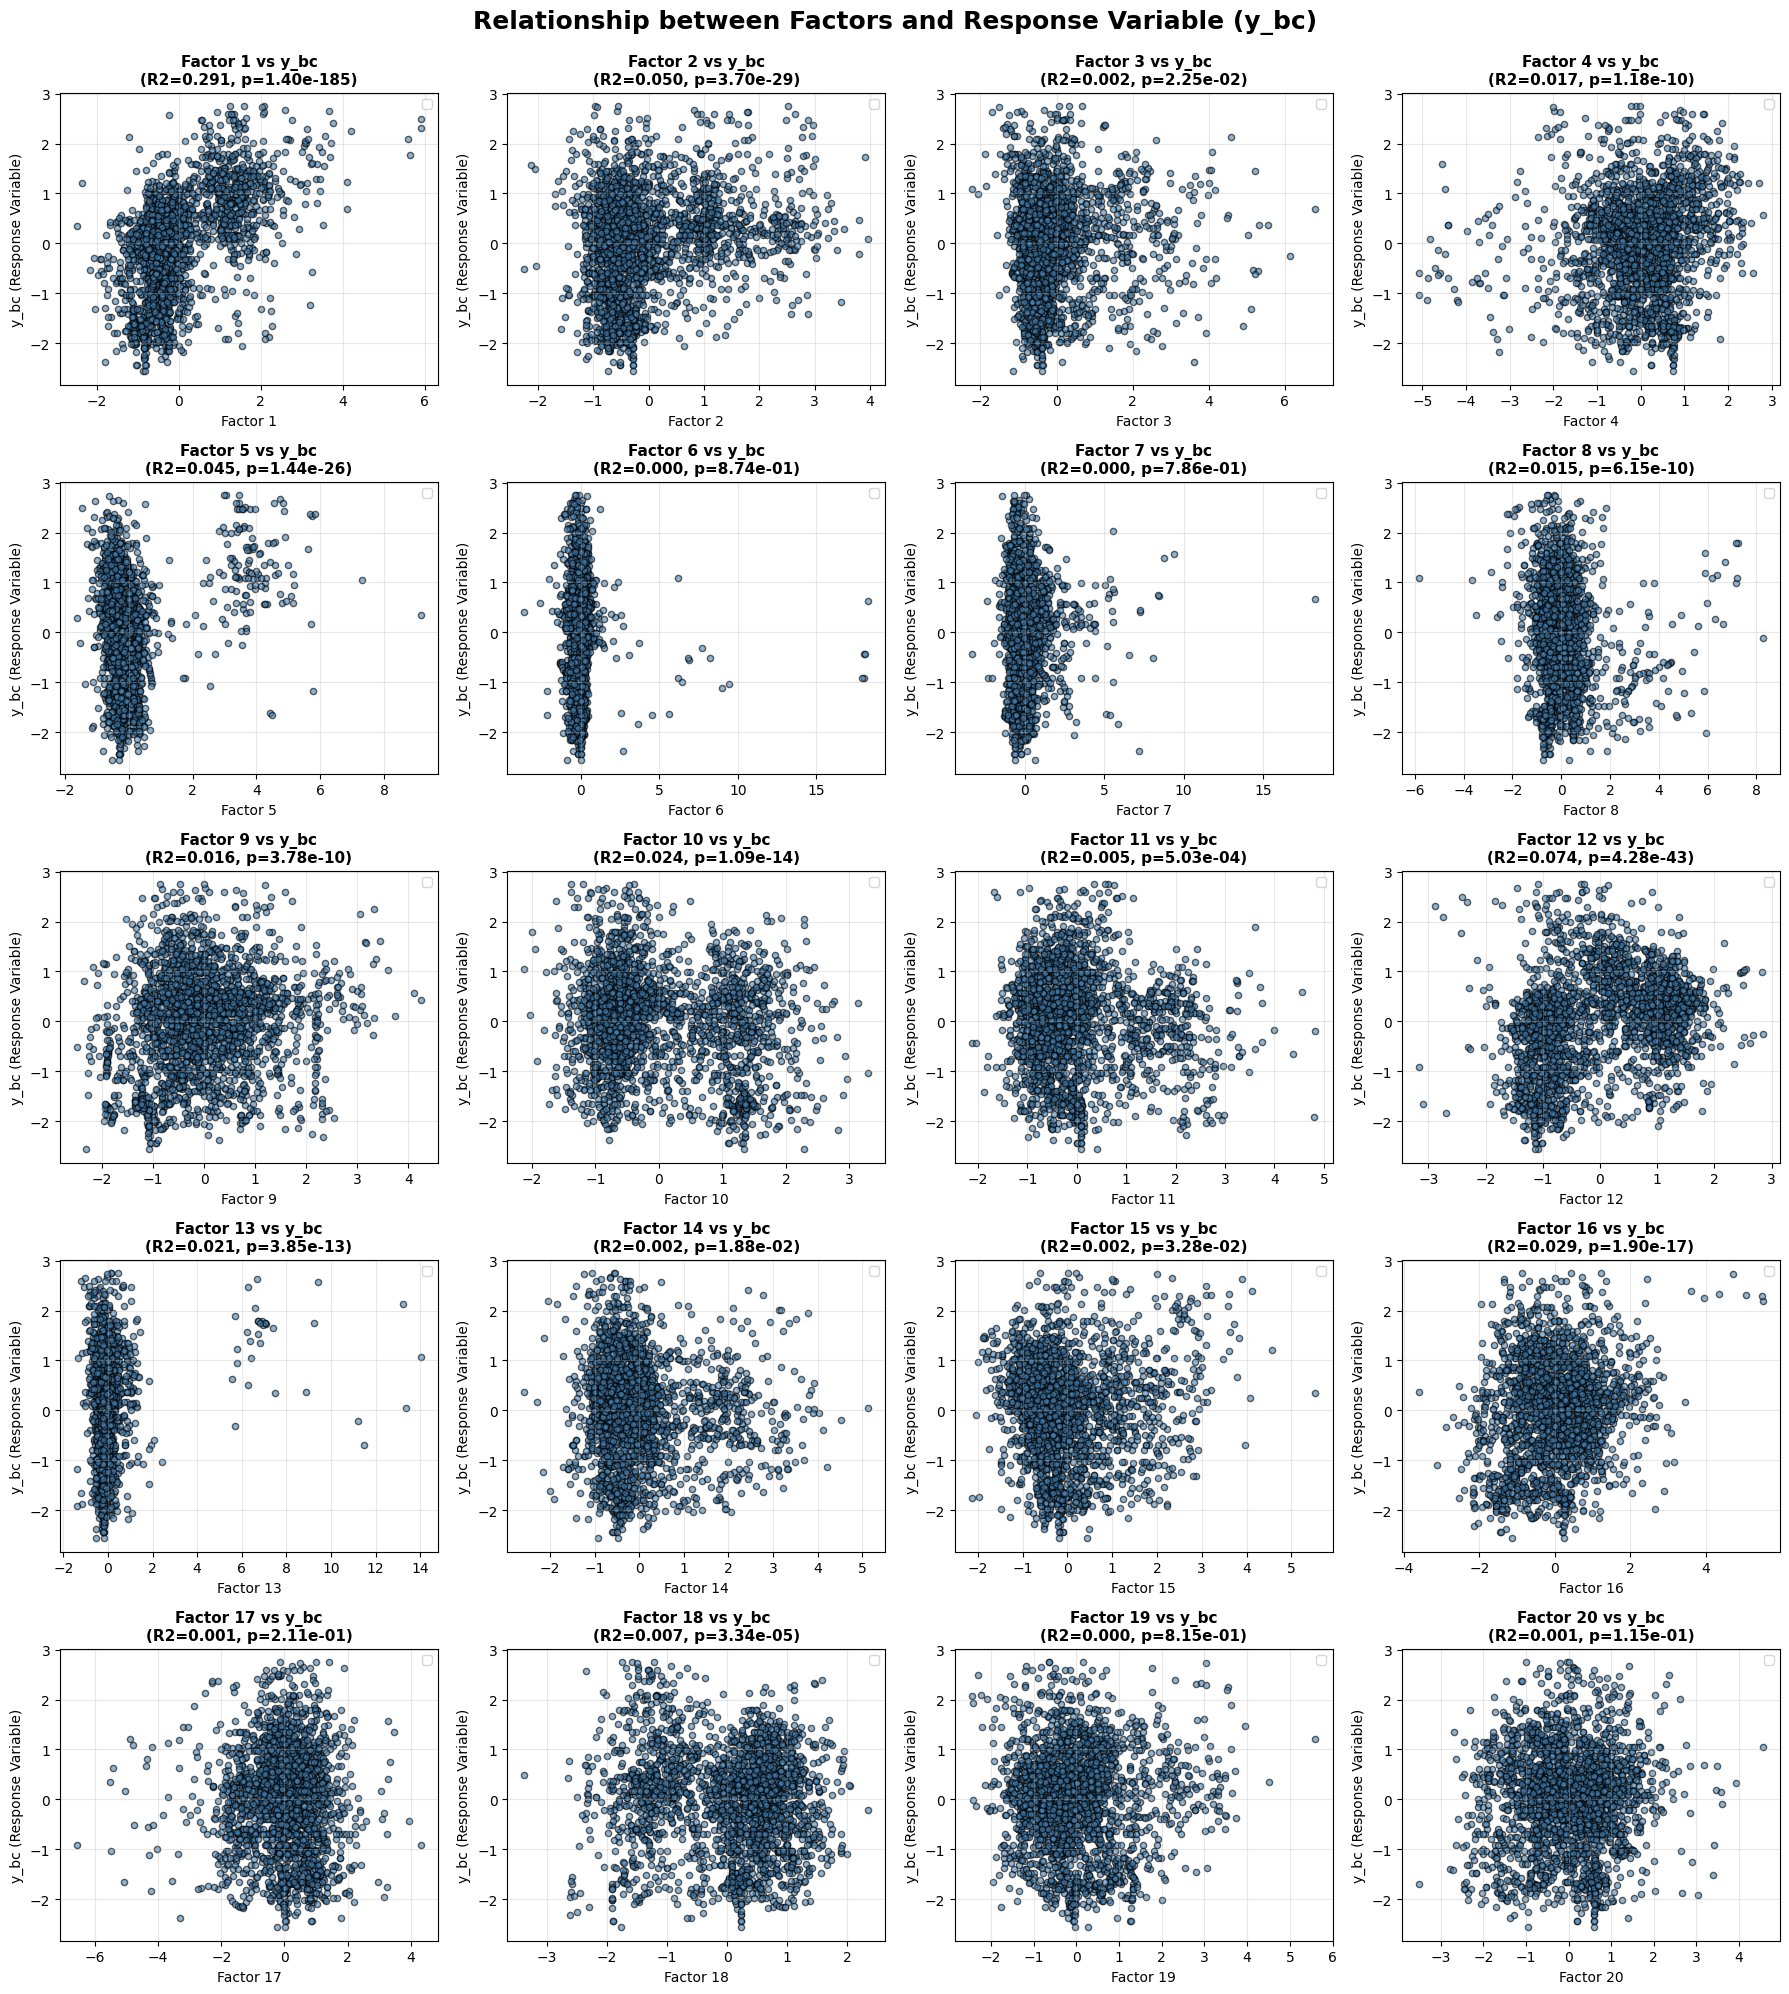

In [29]:

# ====================================================================
# RELATIONSHIP BETWEEN FACTORS AND RESPONSE VARIABLE (y_bc)
# ====================================================================

print("="*60)
print("ANALYSIS: Relationship between Factors and Response Variable")
print("="*60)


# Create grid of 5 rows x 4 columns (20 plots)
fig, axes = plt.subplots(5, 4, figsize=(18, 20))
axes = axes.flatten()

for i in range(20):
    factor_data = X_factores[:, i]
    ax = axes[i]

    # Scatter plot of observed points
    ax.scatter(factor_data, y_bc, alpha=0.6, color='steelblue', edgecolors='k', s=20)
    # Calculate linear regression (slope, intercept, R², p-value)
    slope, intercept, r_value, p_value, std_err = linregress(factor_data, y_bc)
    # Plot regression line
    x_line = np.array([factor_data.min(), factor_data.max()])
#
    # Configure labels and titles with metrics
    ax.set_title(f'Factor {i+1} vs y_bc\n(R2={r_value**2:.3f}, p={p_value:.2e})',
                 fontsize=11, fontweight='bold')
    ax.set_xlabel(f'Factor {i+1}')
    ax.set_ylabel('y_bc (Response Variable)')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=9)

plt.suptitle('Relationship between Factors and Response Variable (y_bc)', fontsize=18, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()


START: Model Training and Evaluation

Step 2: Models to evaluate
------------------------------------------------------------
Evaluating 5 different models

Step 3: Training and Evaluation
------------------------------------------------------------

Evaluating target: Original (y_fill)

Evaluating target: Transformed Box-Cox (y_bc)


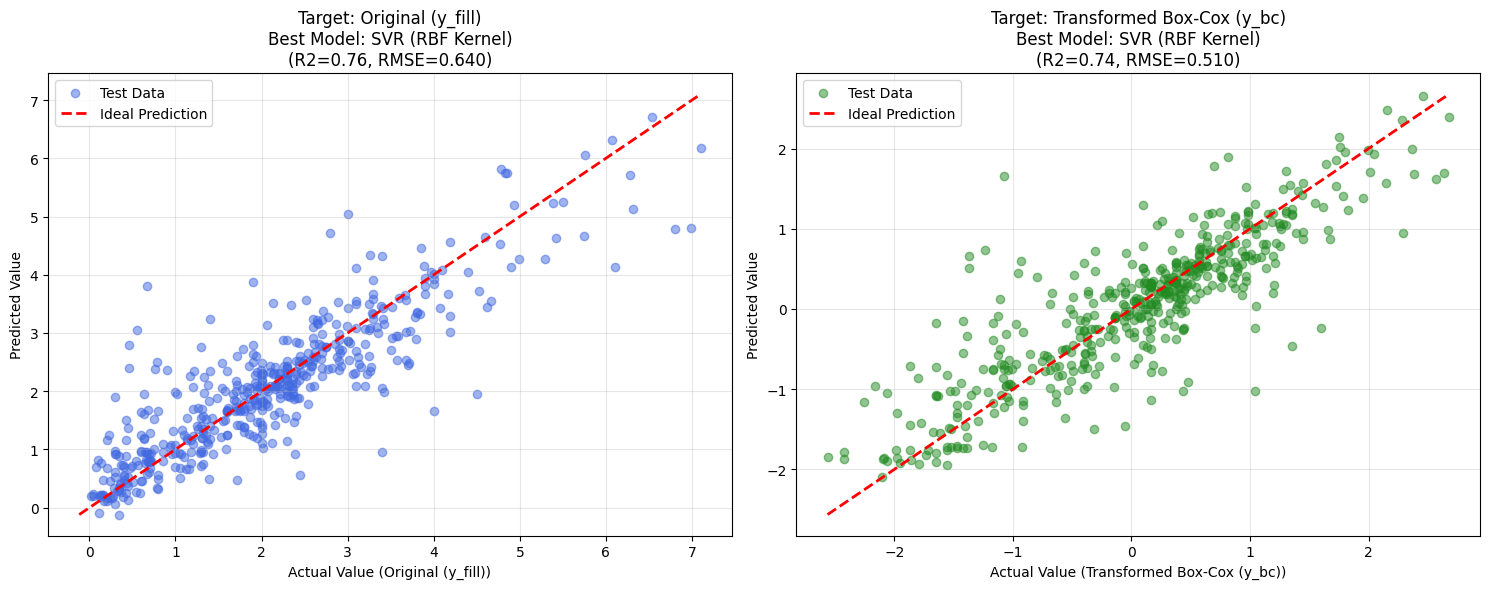


RESULTS: Model Performance

1. R2 Score (Fit Quality - Higher is better)
------------------------------------------------------------
Target                     Original (y_fill)  Transformed Box-Cox (y_bc)
Model                                                                   
SVR (RBF Kernel)                    0.762580                    0.735409
Random Forest                       0.732871                    0.723967
Gradient Boosting                   0.682540                    0.681636
Ridge (L2 Regularization)           0.606266                    0.589642
Linear Regression                   0.606219                    0.589616

2. RMSE (Average Error - Lower is better)
------------------------------------------------------------
Target                     Original (y_fill)  Transformed Box-Cox (y_bc)
Model                                                                   
SVR (RBF Kernel)                    0.640169                    0.510269
Random Forest                  

In [30]:

# ====================================================================
# MODELING AND EVALUATION OF DIFFERENT ALGORITHMS
# ====================================================================
print("="*60)
print("START: Model Training and Evaluation")
print("="*60)
# Step 1: Define target variables
# Two versions of the response variable are compared: original and transformed
y_targets = {
    'Original (y_fill)': y_fill,
    'Transformed Box-Cox (y_bc)': y_bc
}
if X_factores.shape[0] != y_fill.shape[0]:
    raise ValueError(f"Error: Row counts do not match. X: {X_factores.shape[0]}, Y: {y_fill.shape[0]}")
# Step 2: Define regression algorithms to test
print("\nStep 2: Models to evaluate")
print("-" * 60)
modelos = {
    'Linear Regression': LinearRegression(),
    'Ridge (L2 Regularization)': Ridge(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'SVR (RBF Kernel)': SVR(kernel='rbf', C=10.0, epsilon=0.1)
}
print(f"Evaluating {len(modelos)} different models")
# Step 3: Training and evaluation loop
print("\nStep 3: Training and Evaluation")
print("-" * 60)
resultados = []
plt.figure(figsize=(15, 6))
plot_idx = 1
for nombre_y, y_actual in y_targets.items():
    print(f"\nEvaluating target: {nombre_y}")
    # Train/test split (80/20)
    X_train, X_test, y_train, y_test = train_test_split(
        X_factores, y_actual, test_size=0.2, random_state=42
    )
    mejor_r2 = -np.inf
    mejor_modelo_nombre = None
    predicciones_mejor = None
    for nombre_modelo, modelo in modelos.items():
        # Training
        modelo.fit(X_train, y_train)
        # Prediction
        y_pred = modelo.predict(X_test)
        # Evaluation: R2, RMSE (Root Mean Squared Error), MAE (Mean Absolute Error)
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        resultados.append({
            'Target': nombre_y,
            'Model': nombre_modelo,
            'R2 Score': r2,
            'RMSE': rmse,
            'MAE': mae
        })

        # Record the best model (based on R2)
        if r2 > mejor_r2:
            mejor_r2 = r2
            mejor_modelo_nombre = nombre_modelo
            predicciones_mejor = y_pred

    # Step 4: Visualization of the best model for each objective
    # Plot actual vs. predicted values

    plt.subplot(1, 2, plot_idx)

    color_punto = 'royalblue' if plot_idx == 1 else 'forestgreen'
    plt.scatter(y_test, predicciones_mejor, alpha=0.5, color=color_punto, label='Test Data')

    # Reference line (perfect prediction)
    min_val = min(np.min(y_test), np.min(predicciones_mejor))
    max_val = max(np.max(y_test), np.max(predicciones_mejor))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Ideal Prediction')

    rmse_mejor = np.sqrt(mean_squared_error(y_test, predicciones_mejor))
    plt.title(f"Target: {nombre_y}\nBest Model: {mejor_modelo_nombre}\n(R2={mejor_r2:.2f}, RMSE={rmse_mejor:.3f})")
    plt.xlabel(f"Actual Value ({nombre_y})")
    plt.ylabel("Predicted Value")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plot_idx += 1

plt.tight_layout()
plt.show()

# Step 5: Summary of results in tables

print("\n" + "="*60)
print("RESULTS: Model Performance")
print("="*60)

df_resultados = pd.DataFrame(resultados)

# Table 1: Coefficient of determination (R2) - Higher is better
print("\n1. R2 Score (Fit Quality - Higher is better)")
print("-" * 60)
pivot_r2 = df_resultados.pivot(index='Model', columns='Target', values='R2 Score')
print(pivot_r2.sort_values(by='Transformed Box-Cox (y_bc)', ascending=False))

# Table 2: Root Mean Squared Error (RMSE) - Lower is better
print("\n2. RMSE (Average Error - Lower is better)")
print("-" * 60)
pivot_rmse = df_resultados.pivot(index='Model', columns='Target', values='RMSE')
print(pivot_rmse.sort_values(by='Transformed Box-Cox (y_bc)', ascending=True))

# Table 3: Mean Absolute Error (MAE) - Lower is better
print("\n3. MAE (Average Absolute Error - Lower is better)")
print("-" * 60)
pivot_mae = df_resultados.pivot(index='Model', columns='Target', values='MAE')
print(pivot_mae.sort_values(by='Transformed Box-Cox (y_bc)', ascending=True))


Training 20 combinations...


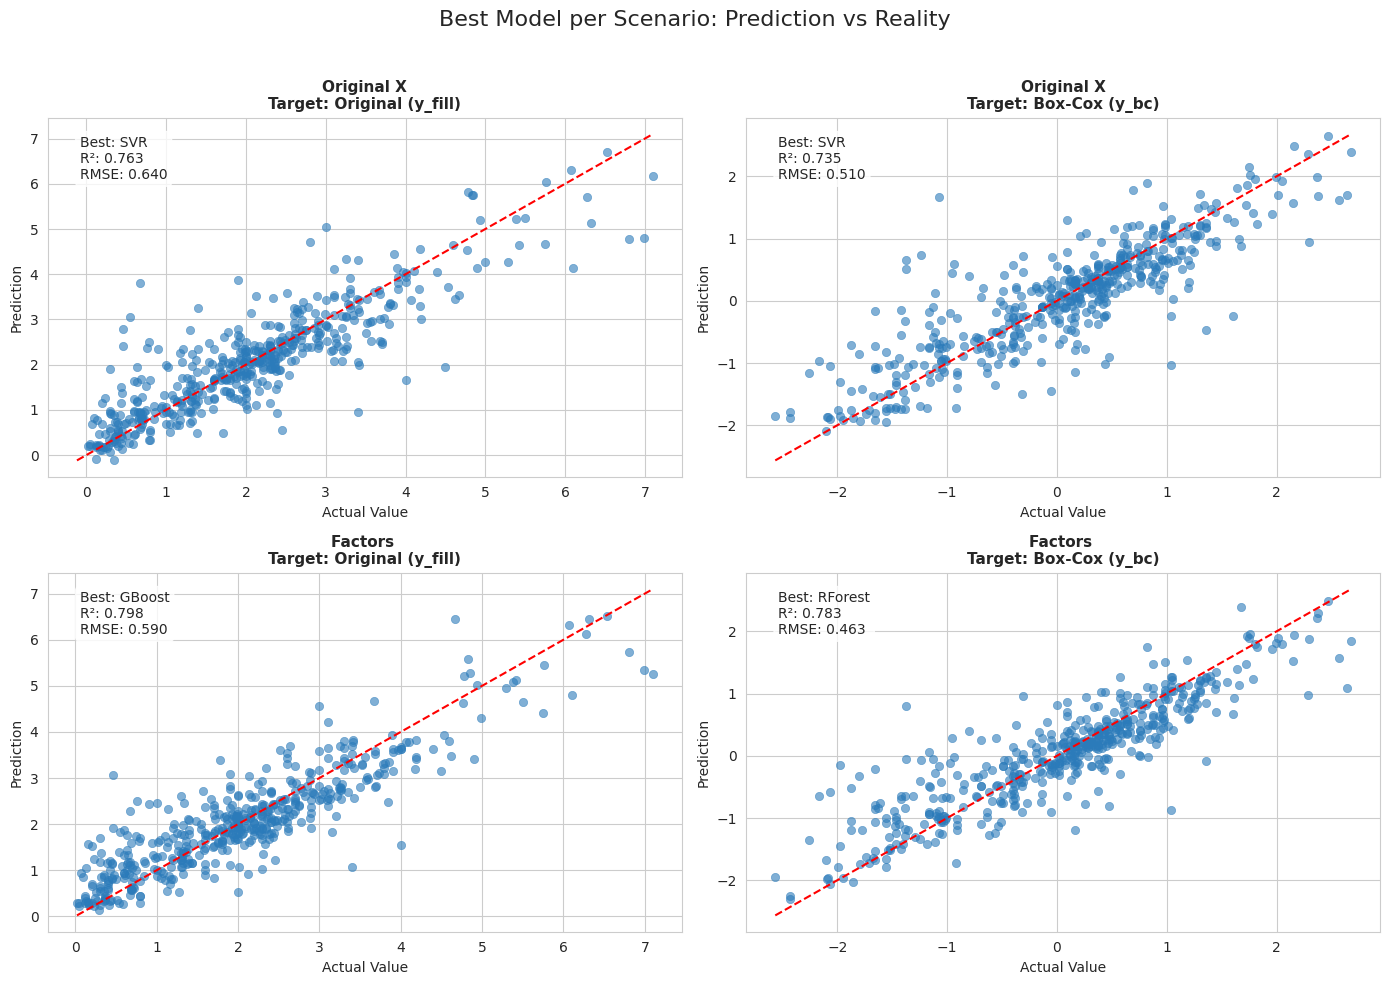

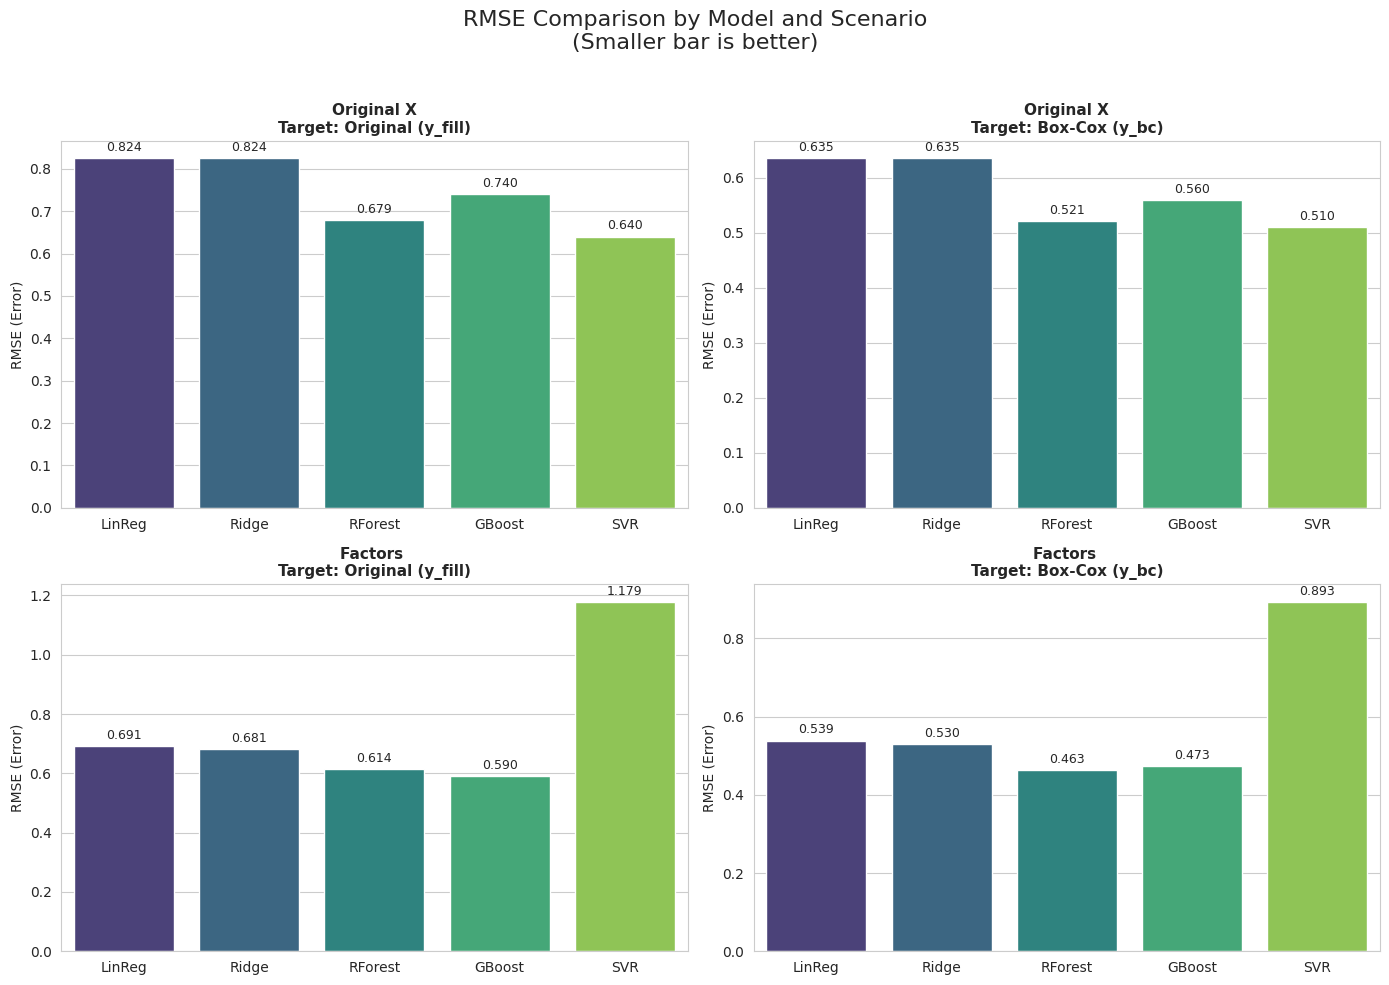


 TABULAR SUMMARY OF RESULTS

>>> TABLE 1: R2 SCORE (Fit Quality - Higher is better)
Target              Box-Cox (y_bc)  Original (y_fill)  Average
Features   Model                                              
Factors    GBoost           0.7724             0.7981   0.7853
           RForest          0.7826             0.7819   0.7823
Original X SVR              0.7354             0.7626   0.7490
           RForest          0.7240             0.7329   0.7284
Factors    Ridge            0.7148             0.7312   0.7230
           LinReg           0.7052             0.7235   0.7143
Original X GBoost           0.6816             0.6825   0.6821
           Ridge            0.5896             0.6063   0.5980
           LinReg           0.5896             0.6062   0.5979
Factors    SVR              0.1889             0.1954   0.1921

>>> TABLE 2: RMSE (Root Mean Squared Error - Lower is better)
Target              Box-Cox (y_bc)  Original (y_fill)  Average
Features   Model                 

In [31]:
# Visual style configuration
sns.set_style("whitegrid")
plt.rcParams.update({'figure.max_open_warning': 0})

# ====================================================================
# DATA CONFIGURATION
# ====================================================================

# 1. Target Variables
y_targets = {
    'Original (y_fill)': y_fill,
    'Box-Cox (y_bc)': y_bc
}

# 2. Independent Variables (Features)
inputs_X = {
    'Original X': X_factores,
    'Factors ': X
}

# 3. Algorithms
modelos = {
    'LinReg': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'RForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'GBoost': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'SVR': SVR(kernel='rbf', C=10.0, epsilon=0.1)
}

resultados = []
best_models_preds = {}
print(f"Training {len(inputs_X) * len(y_targets) * len(modelos)} combinations...")
for nombre_X, data_X in inputs_X.items():
    for nombre_y, y_actual in y_targets.items():
        X_train, X_test, y_train, y_test = train_test_split(data_X, y_actual, test_size=0.2, random_state=42)
        mejor_r2_local = -np.inf
        for nombre_modelo, modelo in modelos.items():
            modelo.fit(X_train, y_train)
            y_pred = modelo.predict(X_test)

            r2 = r2_score(y_test, y_pred)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            mae = mean_absolute_error(y_test, y_pred)

            resultados.append({
                'Features': nombre_X,
                'Target': nombre_y,
                'Model': nombre_modelo,
                'R2': r2,
                'RMSE': rmse,
                'MAE': mae
            })

            if r2 > mejor_r2_local:
                mejor_r2_local = r2
                clave_grupo = f"{nombre_X} | {nombre_y}"
                best_models_preds[clave_grupo] = {
                    'y_test': y_test,
                    'y_pred': y_pred,
                    'model': nombre_modelo,
                    'r2': r2,
                    'rmse': rmse
                }

df_resultados = pd.DataFrame(resultados)

# ====================================================================
# GRAPH 1: SCATTER PLOT (Actual vs Predicted) - Best Models
# ====================================================================
fig1, axes1 = plt.subplots(2, 2, figsize=(14, 10))
fig1.suptitle('Best Model per Scenario: Prediction vs Reality', fontsize=16, y=0.98)
axes_flat = axes1.flatten()

idx = 0
for nombre_X in inputs_X.keys():
    for nombre_y in y_targets.keys():
        ax = axes_flat[idx]
        clave = f"{nombre_X} | {nombre_y}"
        datos = best_models_preds[clave]

        sns.scatterplot(x=datos['y_test'], y=datos['y_pred'], ax=ax, alpha=0.6, edgecolor=None, color='#2b7bba')
        min_val = min(datos['y_test'].min(), datos['y_pred'].min())
        max_val = max(datos['y_test'].max(), datos['y_pred'].max())
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=1.5, label='Ideal')
        ax.set_title(f"{nombre_X}\nTarget: {nombre_y}", fontsize=11, fontweight='bold')
        ax.set_xlabel("Actual Value")
        ax.set_ylabel("Prediction")

        text_str = f"Best: {datos['model']}\nR²: {datos['r2']:.3f}\nRMSE: {datos['rmse']:.3f}"
        ax.text(0.05, 0.95, text_str, transform=ax.transAxes, fontsize=10,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        idx += 1
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# ====================================================================
# GRAPH 2: RMSE COMPARISON (Bars) - All models
# ====================================================================

fig2, axes2 = plt.subplots(2, 2, figsize=(14, 10))
fig2.suptitle('RMSE Comparison by Model and Scenario\n(Smaller bar is better)', fontsize=16, y=0.98)
axes_flat_2 = axes2.flatten()

idx = 0
for nombre_X in inputs_X.keys():
    for nombre_y in y_targets.keys():
        ax = axes_flat_2[idx]
        data_subset = df_resultados[(df_resultados['Features'] == nombre_X) & (df_resultados['Target'] == nombre_y)]
        bar = sns.barplot(x='Model', y='RMSE', data=data_subset, ax=ax, palette='viridis', hue='Model', legend=False)
        for container in ax.containers:
            ax.bar_label(container, fmt='%.3f', padding=3, fontsize=9)
        ax.set_title(f"{nombre_X}\nTarget: {nombre_y}", fontsize=11, fontweight='bold')
        ax.set_xlabel("")
        ax.set_ylabel("RMSE (Error)")
        idx += 1
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# ====================================================================
# ORDERED RESULTS TABLES
# ====================================================================
pd.set_option('display.float_format', '{:.4f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
print("\n" + "="*80)
print(" TABULAR SUMMARY OF RESULTS")
print("="*80)
# 1. R2 Pivot Table (Quality)
print("\n>>> TABLE 1: R2 SCORE (Fit Quality - Higher is better)")
pivot_r2 = df_resultados.pivot_table(index=['Features', 'Model'], columns='Target', values='R2')
# Order by the average R2 to see which model is generally more robust
pivot_r2['Average'] = pivot_r2.mean(axis=1)
print(pivot_r2.sort_values('Average', ascending=False))
# 2. RMSE Pivot Table (Error)
print("\n>>> TABLE 2: RMSE (Root Mean Squared Error - Lower is better)")
pivot_rmse = df_resultados.pivot_table(index=['Features', 'Model'], columns='Target', values='RMSE')
pivot_rmse['Average'] = pivot_rmse.mean(axis=1)
print(pivot_rmse.sort_values('Average', ascending=True))
# 3. Winners Summary Table
print("\n>>> TABLE 3: CATEGORY WINNERS")
ganadores = df_resultados.loc[df_resultados.groupby(['Features', 'Target'])['R2'].idxmax()]
print(ganadores[['Features', 'Target', 'Model', 'R2', 'RMSE']].to_string(index=False))


Metrics of the visual model (2D):
  R2 Score: 0.3902
  RMSE: 0.7809


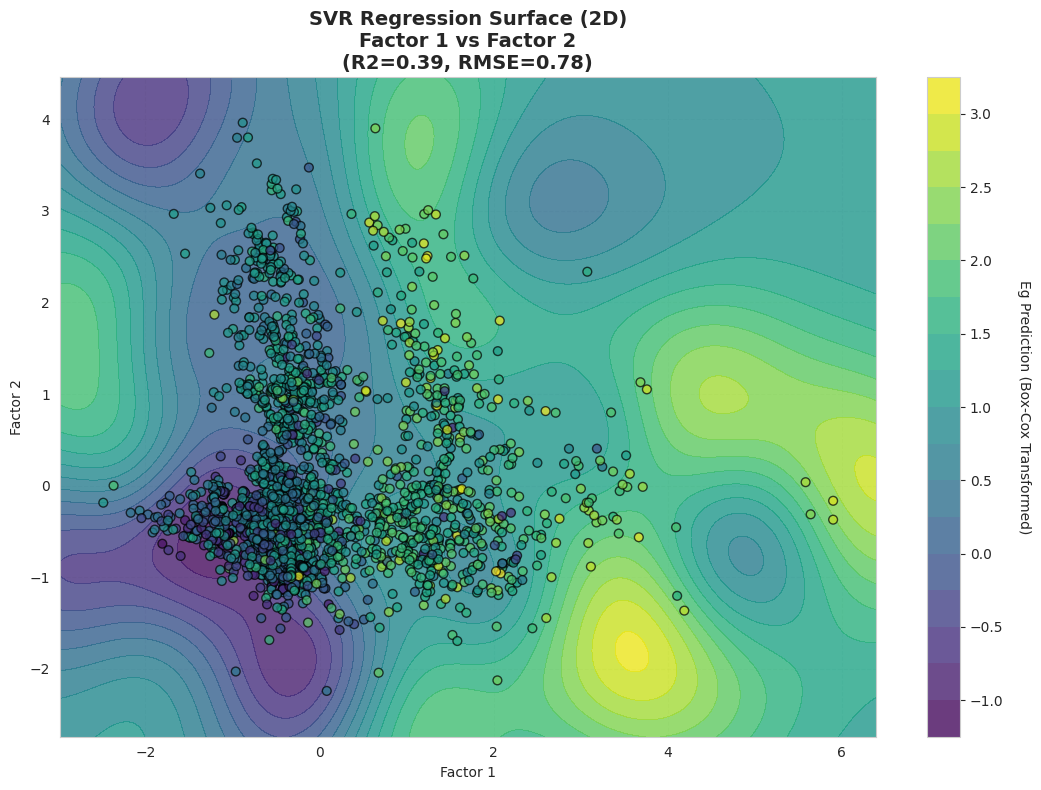

In [32]:

# ====================================================================
# 2D VISUALIZATION: SVR REGRESSION SURFACE
# ====================================================================
# Only the first two factors are used (Factor 1 and Factor 2)
X_vis = X_factores[:, :2]
y_vis = y_bc
# RBF (Radial Basis Function) kernel is used to capture non-linear relationships
svr_2d = SVR(kernel='rbf', C=10.0, epsilon=0.1)
svr_2d.fit(X_vis, y_vis)
# Step 3: 2D model evaluation
y_pred_2d = svr_2d.predict(X_vis)
r2_2d = r2_score(y_vis, y_pred_2d)
rmse_2d = np.sqrt(mean_squared_error(y_vis, y_pred_2d))
print(f"Metrics of the visual model (2D):")
print(f"  R2 Score: {r2_2d:.4f}")
print(f"  RMSE: {rmse_2d:.4f}")
# Step 4: Creation of prediction mesh
# Generates a grid of points to visualize the regression surface
x_min, x_max = X_vis[:, 0].min() - 0.5, X_vis[:, 0].max() + 0.5
y_min, y_max = X_vis[:, 1].min() - 0.5, X_vis[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

# The trained model is used to predict values across the surface
Z = svr_2d.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.figure(figsize=(11, 8))
# Filled contours (prediction surface)
contour = plt.contourf(xx, yy, Z, alpha=0.8, cmap='viridis', levels=20)
cbar = plt.colorbar(contour)
cbar.set_label('Eg Prediction (Box-Cox Transformed)', rotation=270, labelpad=20)
scatter = plt.scatter(X_vis[:, 0], X_vis[:, 1], c=y_vis,
                      cmap='viridis', edgecolors='k', s=40, alpha=0.7)

plt.title(f'SVR Regression Surface (2D)\nFactor 1 vs Factor 2\n(R2={r2_2d:.2f}, RMSE={rmse_2d:.2f})',
          fontsize=14, fontweight='bold')
plt.xlabel('Factor 1')
plt.ylabel('Factor 2')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()
